# Autoencoders

## Import the appropriate modules

In [1]:
from __future__ import print_function, division
from builtins import range, input
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from util import relu, error_rate, getKaggleMNIST, init_weights

## AutoEncoder Class

In [2]:
class AutoEncoder(object):
    """
    M is an arbitrary parameter
    an_id will be used to set names of theano variables
    """
    def __init__(self, M, an_id):
        self.M = M
        self.id = an_id
    """
    Unsupervised, so only takes X
    Epoch and learning rate can be adjusted
    """
    def fit(self, X, learning_rate=0.5, mu=0.99,
            epochs=1, batch_sz=100, show_fig=False):
        N, D = X.shape
        n_batches = N // batch_sz
        
        # Initialize weights
        W0 = init_weights((D, self.M))
        # Theano variables
        self.W = theano.shared(W0, 'W_%s' % self.id)
        self.bh = theano.shared(
            np.zeros(self.M), 'bh_%s' % self.id)
        self.bo = theano.shared(
            np.zeros(D), 'bo_%s' % self.id)
        # Save these in an array for use in the gradient
        # descent part of this process.
        self.params = [self.W, self.bh, self.bo]
        self.forward_params = [self.W, self.bh]

        # TODO: technically these should be reset before doing backprop
        # These are defined for the use of momentum
        self.dW = theano.shared(
            np.zeros(W0.shape), 'dW_%s' % self.id)
        self.dbh = theano.shared(
            np.zeros(self.M), 'dbh_%s' % self.id)
        self.dbo = theano.shared(
            np.zeros(D), 'dbo_%s' % self.id)
        # Parameters collected for use in gradient descent
        self.dparams = [self.dW, self.dbh, self.dbo]
        self.forward_dparams = [self.dW, self.dbh]
    
        # Define tensor input
        X_in = T.matrix('X_%s' % self.id)
        X_hat = self.forward_output(X_in)

        # attach it to the object so it can be used later
        # must be sigmoidal because the output is also a sigmoid!
        H = T.nnet.sigmoid(X_in.dot(self.W) + self.bh)
        self.hidden_op = theano.function(
            inputs=[X_in],
            outputs=H,)

        # save this for later so we can call it to
        # create reconstructions of input
        self.predict = theano.function(
            inputs=[X_in],
            outputs=X_hat,)
        
        # Can also use cross entropy here if needed:
        cost=-(X_in*T.log(X_hat)+(1-X_in)*
                 T.log(1-X_hat)).sum()  / N
        #cost = -(X_in * T.log(X_hat) 
         #        + (1 - X_in) 
          #       * T.log(1 - X_hat)).flatten().mean()
        cost_op = theano.function(
            inputs=[X_in],
            outputs=cost,)
    
        # Gradient Descent
        updates = [(p, p + mu*dp - learning_rate*T.grad(cost, p)
                   ) for p, dp in zip(self.params, self.dparams)]
        + [(dp, mu*dp - learning_rate*T.grad(cost, p)
           ) for p, dp in zip(self.params, self.dparams)]
        
        # Train function
        train_op = theano.function(
            inputs=[X_in],
            updates=updates,)
        
        # Saving costs to plot later
        costs = []
        print("training autoencoder: %s" % self.id)
        for i in range(epochs):
            print("epoch:", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(batch)
                the_cost = cost_op(batch) 
                if(j%400 == 0 ):
                    if j % 10 == 0:
                        print("j / n_batches:", j,
                              "/", n_batches, "cost:", the_cost)
                costs.append(the_cost)
        if show_fig:
            plt.plot(costs)
            plt.show()

    """
    Hidden layers ( sigmoid )
    """
    def forward_hidden(self, X):
        Z = T.nnet.sigmoid(X.dot(self.W) + self.bh)
        return Z

    """
    Output layers ( sigmoid )
    """
    def forward_output(self, X):
        Z = self.forward_hidden(X)
        Y = T.nnet.sigmoid(Z.dot(self.W.T) + self.bo)
        return Y

    @staticmethod
    def createFromArrays(W, bh, bo, an_id):
        ae = AutoEncoder(W.shape[1], an_id)
        ae.W = theano.shared(W, 'W_%s' % ae.id)
        ae.bh = theano.shared(bh, 'bh_%s' % ae.id)
        ae.bo = theano.shared(bo, 'bo_%s' % ae.id)
        ae.params = [ae.W, ae.bh, ae.bo]
        ae.forward_params = [ae.W, ae.bh]
        return ae


## DNN Class

In [3]:
class DNN(object):
    """
    hidden layer sizes will be an array of numbers
    """
    def __init__(self, hidden_layer_sizes,
                 UnsupervisedModel=AutoEncoder):
        self.hidden_layers = []
        # Keeps ID of each autoencoder
        count = 0
        for M in hidden_layer_sizes:
            ae = UnsupervisedModel(M, count)
            self.hidden_layers.append(ae)
            count += 1

    """
    Supervised, so we have X and y
    Usually don't want to use test data here.
    This fitting uses momentum and regularization.
    """
    def fit(self, X, Y, Xtest, Ytest,
            pretrain=True, learning_rate=0.01,
            mu=0.99, reg=0.1, epochs=1, batch_sz=100):
        # greedy layer-wise training of autoencoders
        pretrain_epochs = 1
        if not pretrain:
            pretrain_epochs = 0

        current_input = X
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=pretrain_epochs)
            # create current_input for the next layer
            current_input = ae.hidden_op(current_input)
        
        # initialize logistic regression layer
        N = len(Y)
        K = len(set(Y))
        W0 = init_weights((self.hidden_layers[-1].M, K))
        
        # Theano Variables
        self.W = theano.shared(W0, "W_logreg")
        self.b = theano.shared(np.zeros(K), "b_logreg")
        
        # Parameters for gradient descent
        self.params = [self.W, self.b]
        for ae in self.hidden_layers:
            self.params += ae.forward_params

        # for momentum
        self.dW = theano.shared(
            np.zeros(W0.shape), "dW_logreg")
        self.db = theano.shared(
            np.zeros(K), "db_logreg")
        self.dparams = [self.dW, self.db]
        for ae in self.hidden_layers:
            self.dparams += ae.forward_dparams
        
        # Define input and output tensors
        X_in = T.matrix('X_in')
        targets = T.ivector('Targets')
        pY = self.forward(X_in)

        squared_magnitude = [
            (p*p).sum() for p in self.params]
        reg_cost = T.sum(squared_magnitude)
        cost = -T.mean(
            T.log(pY[T.arange(pY.shape[0]),
                     targets]))+reg_cost
        prediction = self.predict(X_in)
        
        # Regularization cost
        cost_predict_op = theano.function(
            inputs=[X_in, targets],
            outputs=[cost, prediction],)

        updates = [(p, p + mu*dp - learning_rate*T.grad(cost, p)
                   ) for p, dp in zip(self.params, self.dparams)] 
        + [(dp, mu*dp - learning_rate*T.grad(cost, p)
           ) for p, dp in zip(self.params, self.dparams)]
        # updates = [(p, p - learning_rate*
        #    T.grad(cost, p)) for p in self.params]
        train_op = theano.function(
            inputs=[X_in, targets],
            updates=updates,)

        n_batches = N // batch_sz
        costs = []
        print("supervised training...")
        for i in range(epochs):
            print("epoch:", i)
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(Xbatch, Ybatch)
                the_cost, the_prediction = cost_predict_op(Xtest, Ytest)
                error = error_rate(the_prediction, Ytest)
                if(j%400==0):
                    print("j / n_batches:", j, "/",
                          n_batches, "cost:", the_cost, "error:", error)
                costs.append(the_cost)
        plt.plot(costs)
        plt.show()
        
    """
    Prediction
    """
    def predict(self, X):
        return T.argmax(self.forward(X), axis=1)
    
    """
    Next node
    """
    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        # logistic layer
        Y = T.nnet.softmax(T.dot(current_input, self.W) + self.b)
        return Y

## Testing a single autoencoder

In [4]:
def test_single_autoencoder():
    Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()

    autoencoder = AutoEncoder(300, 0)
    autoencoder.fit(Xtrain, epochs=2, show_fig=True)

    done = False
    while not done:
        i = np.random.choice(len(Xtest))
        x = Xtest[i]
        y = autoencoder.predict([x])
        plt.subplot(1,2,1)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.title('Original')

        plt.subplot(1,2,2)
        plt.imshow(y.reshape(28,28), cmap='gray')
        plt.title('Reconstructed')

        plt.show()

        ans = input("Generate another?")
        if ans and ans[0] in ('n' or 'N'):
            done = True


## Running the test

training autoencoder: 0
epoch: 0
j / n_batches: 0 / 410 cost: 0.6864583118699961
j / n_batches: 10 / 410 cost: 0.4083545705704121
j / n_batches: 20 / 410 cost: 0.27487047764985295
j / n_batches: 30 / 410 cost: 0.2612866868552625
j / n_batches: 40 / 410 cost: 0.2442525046929714
j / n_batches: 50 / 410 cost: 0.2625823924904911
j / n_batches: 60 / 410 cost: 0.2627323088835687
j / n_batches: 70 / 410 cost: 0.24922317948741846
j / n_batches: 80 / 410 cost: 0.24668690594169393
j / n_batches: 90 / 410 cost: 0.23435230221539577
j / n_batches: 100 / 410 cost: 0.22599702608964328
j / n_batches: 110 / 410 cost: 0.2144034667492117
j / n_batches: 120 / 410 cost: 0.2086142283171573
j / n_batches: 130 / 410 cost: 0.215949612274895
j / n_batches: 140 / 410 cost: 0.21212727696929196
j / n_batches: 150 / 410 cost: 0.1963612543874787
j / n_batches: 160 / 410 cost: 0.20187505307670223
j / n_batches: 170 / 410 cost: 0.1926247852954334
j / n_batches: 180 / 410 cost: 0.18188612219283973
j / n_batches: 190 / 

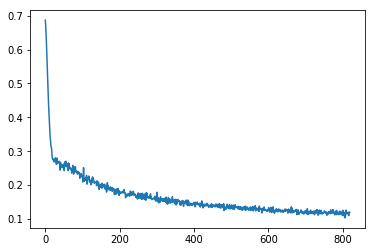

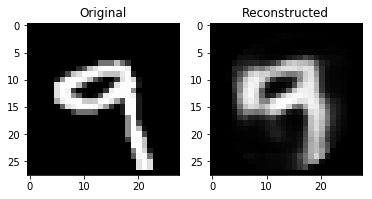

Generate another?y


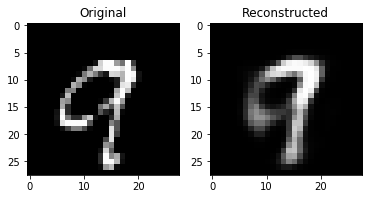

Generate another?y


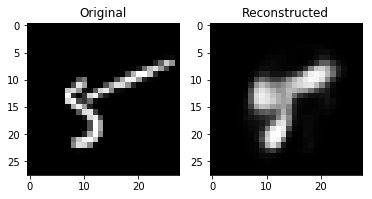

Generate another?y


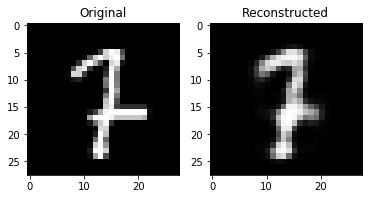

Generate another?y


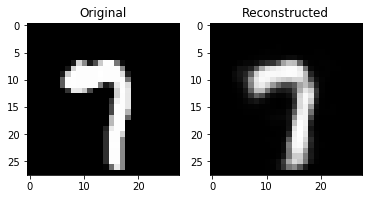

Generate another?y


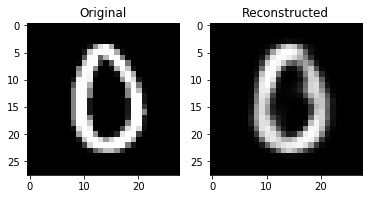

Generate another?n


In [9]:
test_single_autoencoder()

Here we see that the autoencoder ran for two epochs and generated a fairly accurate representation of the original numbers.

## Running the AutoEncoder (LONG OUTPUT)

training autoencoder: 0
training autoencoder: 1
training autoencoder: 2
supervised training...
epoch: 0
j / n_batches: 0 / 410 cost: 1133.5626991975137 error: 0.917
j / n_batches: 400 / 410 cost: 21.603151058604755 error: 0.887
epoch: 1
j / n_batches: 0 / 410 cost: 3.802571193880928 error: 0.899
j / n_batches: 400 / 410 cost: 2.4457724252970166 error: 0.899
epoch: 2
j / n_batches: 0 / 410 cost: 2.8124273381509677 error: 0.894
j / n_batches: 400 / 410 cost: 2.6643533773882586 error: 0.901


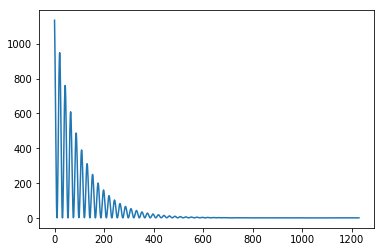

In [5]:
Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
# dnn = DNN([1000, 750, 500])
# dnn.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=3)
# vs
dnn = DNN([1000, 750, 500])
dnn.fit(Xtrain, Ytrain, Xtest,
        Ytest, pretrain=False, epochs=3)
# You'll definitely want to crank those epochs up.

# TensorFlow Autoencoder

## Importing the appropriate modules

In [1]:
from __future__ import print_function, division
from builtins import range, input
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from util import error_rate, getKaggleMNIST

## Autoencoder class

In [2]:
class AutoEncoder(object):
    """
    Take input variables then call biuld function.
    """
    def __init__(self, D, M, an_id):
        self.M = M
        self.id = an_id
        self.build(D, M)

    """
    Setter for session
    """
    def set_session(self, session):
        self.session = session

        
    """
    Creates tensorFlow variables for each input
    """
    def build(self, D, M):
        # instance variables to call later
        self.W = tf.Variable(
            tf.random_normal(shape=(D, M)))
        self.bh = tf.Variable(
            np.zeros(M).astype(np.float32))
        self.bo = tf.Variable(
            np.zeros(D).astype(np.float32))

        self.X_in = tf.placeholder(
            tf.float32, shape=(None, D))
        self.Z = self.forward_hidden(self.X_in) # for transform() later
        self.X_hat = self.forward_output(self.X_in)


        # using the naive formulation for cross-entropy
        # will have numerical stability issues if X_hat = 0 or 1
        logits = self.forward_logits(self.X_in)
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.X_in,
                logits=logits,))

        self.train_op = tf.train.AdamOptimizer(
            1e-1).minimize(self.cost)
        # self.train_op = tf.train.MomentumOptimizer(10e-4, momentum=0.9).minimize(self.cost)

        
    """
    Simple because the NN is already built.
    Randomizes and calls through loop
    """
    def fit(self, X, epochs=1, batch_sz=100, show_fig=False):
        N, D = X.shape
        n_batches = N // batch_sz

        costs = []
        print("training autoencoder: %s" % self.id)
        for i in range(epochs):
            print("epoch:", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                _, c = self.session.run((
                    self.train_op, self.cost),
                    feed_dict={self.X_in: batch})
                if j % 10 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", c)
                costs.append(c)
        if show_fig:
            plt.plot(costs)
            plt.show()

            
    """
    Numpy to numpy Hidden layer function
    """
    def transform(self, X):
        # accepts and returns a real numpy array
        # unlike forward_hidden and forward_output
        # which deal with tensorflow variables
        return self.session.run(self.Z, feed_dict={self.X_in: X})

    """
    Numpy to numpy Hidden layer function
    """
    def predict(self, X):
        # accepts and returns a real numpy array
        # unlike forward_hidden and forward_output
        # which deal with tensorflow variables
        return self.session.run(self.X_hat, feed_dict={self.X_in: X})

    """
    Tensorflow to tensorflow
    """
    def forward_hidden(self, X):
        Z = tf.nn.sigmoid(tf.matmul(X, self.W) + self.bh)
        return Z

    """
    Tensorflow to tensorflow
    """
    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        return tf.matmul(Z, tf.transpose(self.W)) + self.bo

    """
    Tensorflow to tensorflow
    """
    def forward_output(self, X):
        return tf.nn.sigmoid(self.forward_logits(X))

## DNN Class

In [3]:
class DNN(object):
    """
    Hidden deep NN
    """
    def __init__(self, D, hidden_layer_sizes,
                 K, UnsupervisedModel=AutoEncoder):
        self.hidden_layers = []
        count = 0
        input_size = D
        for output_size in hidden_layer_sizes:
            ae = UnsupervisedModel(
                input_size, output_size, count)
            self.hidden_layers.append(ae)
            count += 1
            input_size = output_size
        self.build_final_layer(D, hidden_layer_sizes[-1], K)

    """
    Setter for session for each hidden layer
    """
    def set_session(self, session):
        self.session = session
        for layer in self.hidden_layers:
            layer.set_session(session)

    """
    Final layer
    """
    def build_final_layer(self, D, M, K):
        # initialize logistic regression layer
        self.W = tf.Variable(tf.random_normal(shape=(M, K)))
        self.b = tf.Variable(np.zeros(K).astype(np.float32))

        self.X = tf.placeholder(tf.float32, shape=(None, D))
        labels = tf.placeholder(tf.int32, shape=(None,))
        self.Y = labels
        logits = self.forward(self.X)

        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits,
                labels=labels))
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(self.cost)
        self.prediction = tf.argmax(logits, 1)

    """
    Takes in train and test, greedy is boolean
    """
    def fit(self, X, Y, Xtest, Ytest,
            pretrain=True, epochs=1, batch_sz=100):
        N = len(X)

        # greedy layer-wise training of autoencoders
        pretrain_epochs = 1
        if not pretrain:
            pretrain_epochs = 0

        current_input = X
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=pretrain_epochs)

            # create current_input for the next layer
            current_input = ae.transform(current_input)

        n_batches = N // batch_sz
        costs = []
        print("supervised training...")
        for i in range(epochs):
            print("epoch:", i)
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]
                self.session.run(
                    self.train_op,
                    feed_dict={self.X: Xbatch, self.Y: Ybatch})
                c, p = self.session.run(
                    (self.cost, self.prediction),
                    feed_dict={self.X: Xtest, self.Y: Ytest})
                error = error_rate(p, Ytest)
                if j % 10 == 0:
                    print("j / n_batches:", j, "/",
                          n_batches, "cost:", c, "error:", error)
                costs.append(c)
        plt.plot(costs)
        plt.show()

    """
    Goes up to logits, TF-TF
    """
    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        # logistic layer
        logits = tf.matmul(current_input, self.W) + self.b
        return logits


## Testing the dnn

In [4]:
def test_pretraining_dnn():
    Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
    # dnn = DNN([1000, 750, 500])
    # dnn.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=3)
    # vs
    Xtrain = Xtrain.astype(np.float32)
    Xtest = Xtest.astype(np.float32)
    _, D = Xtrain.shape
    K = len(set(Ytrain))
    dnn = DNN(D, [1000, 750, 500], K)
    init_op = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init_op)
        dnn.set_session(session)
        dnn.fit(Xtrain, Ytrain, Xtest,
                Ytest, pretrain=True, epochs=10)

## Testing a single autoencoder

In [7]:
def test_single_autoencoder():
    Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
    Xtrain = Xtrain.astype(np.float32)
    Xtest = Xtest.astype(np.float32)

    _, D = Xtrain.shape
    print(D)
    autoencoder = AutoEncoder(D, 300,0)
    init_op = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init_op)
        autoencoder.set_session(session)
        autoencoder.fit(Xtrain, show_fig=True)

        done = False
        while not done:
            i = np.random.choice(len(Xtest))
            x = Xtest[i]
            y = autoencoder.predict([x])
            plt.subplot(1,2,1)
            plt.imshow(x.reshape(28,28), cmap='gray')
            plt.title('Original')

            plt.subplot(1,2,2)
            plt.imshow(y.reshape(28,28), cmap='gray')
            plt.title('Reconstructed')

            plt.show()

            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True


## Running the test

784
training autoencoder: 0
epoch: 0
j / n_batches: 0 / 410 cost: 4.64019
j / n_batches: 10 / 410 cost: 0.303542
j / n_batches: 20 / 410 cost: 0.232976
j / n_batches: 30 / 410 cost: 0.212464
j / n_batches: 40 / 410 cost: 0.203958
j / n_batches: 50 / 410 cost: 0.198198
j / n_batches: 60 / 410 cost: 0.186505
j / n_batches: 70 / 410 cost: 0.170297
j / n_batches: 80 / 410 cost: 0.173321
j / n_batches: 90 / 410 cost: 0.161602
j / n_batches: 100 / 410 cost: 0.160524
j / n_batches: 110 / 410 cost: 0.157753
j / n_batches: 120 / 410 cost: 0.151965
j / n_batches: 130 / 410 cost: 0.153976
j / n_batches: 140 / 410 cost: 0.158943
j / n_batches: 150 / 410 cost: 0.138085
j / n_batches: 160 / 410 cost: 0.14589
j / n_batches: 170 / 410 cost: 0.142765
j / n_batches: 180 / 410 cost: 0.159547
j / n_batches: 190 / 410 cost: 0.135499
j / n_batches: 200 / 410 cost: 0.130431
j / n_batches: 210 / 410 cost: 0.142418
j / n_batches: 220 / 410 cost: 0.141606
j / n_batches: 230 / 410 cost: 0.134821
j / n_batches: 2

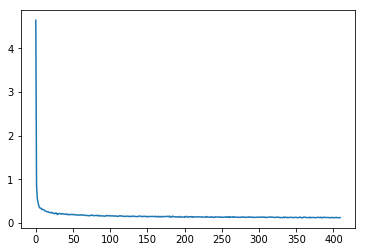

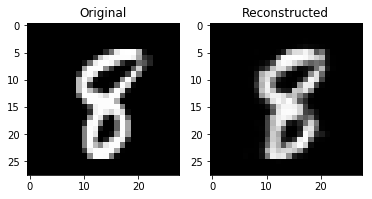

Generate another?


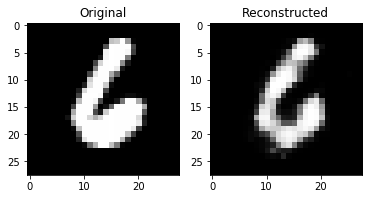

Generate another?


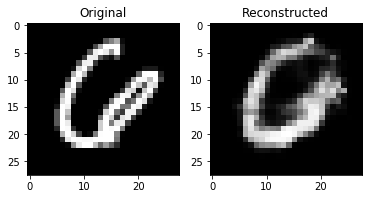

Generate another?


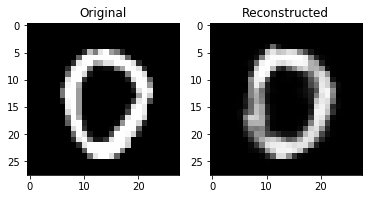

Generate another?y


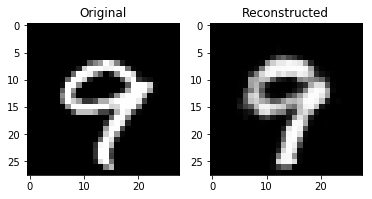

Generate another?n


In [8]:
test_single_autoencoder()

## Running the DNN  ( LONG OUTPUT)

training autoencoder: 0
epoch: 0
j / n_batches: 0 / 410 cost: 8.32554
j / n_batches: 10 / 410 cost: 0.288521
j / n_batches: 20 / 410 cost: 0.240427
j / n_batches: 30 / 410 cost: 0.208209
j / n_batches: 40 / 410 cost: 0.188207
j / n_batches: 50 / 410 cost: 0.197097
j / n_batches: 60 / 410 cost: 0.173092
j / n_batches: 70 / 410 cost: 0.172895
j / n_batches: 80 / 410 cost: 0.150908
j / n_batches: 90 / 410 cost: 0.163357
j / n_batches: 100 / 410 cost: 0.155598
j / n_batches: 110 / 410 cost: 0.15084
j / n_batches: 120 / 410 cost: 0.152299
j / n_batches: 130 / 410 cost: 0.138424
j / n_batches: 140 / 410 cost: 0.14347
j / n_batches: 150 / 410 cost: 0.136149
j / n_batches: 160 / 410 cost: 0.141237
j / n_batches: 170 / 410 cost: 0.134323
j / n_batches: 180 / 410 cost: 0.128744
j / n_batches: 190 / 410 cost: 0.141049
j / n_batches: 200 / 410 cost: 0.129385
j / n_batches: 210 / 410 cost: 0.133327
j / n_batches: 220 / 410 cost: 0.132665
j / n_batches: 230 / 410 cost: 0.134684
j / n_batches: 240 / 

j / n_batches: 190 / 410 cost: 0.170045 error: 0.047
j / n_batches: 200 / 410 cost: 0.181708 error: 0.049
j / n_batches: 210 / 410 cost: 0.181195 error: 0.054
j / n_batches: 220 / 410 cost: 0.163971 error: 0.047
j / n_batches: 230 / 410 cost: 0.186278 error: 0.05
j / n_batches: 240 / 410 cost: 0.209852 error: 0.061
j / n_batches: 250 / 410 cost: 0.197792 error: 0.052
j / n_batches: 260 / 410 cost: 0.199144 error: 0.049
j / n_batches: 270 / 410 cost: 0.209598 error: 0.051
j / n_batches: 280 / 410 cost: 0.203035 error: 0.056
j / n_batches: 290 / 410 cost: 0.2077 error: 0.062
j / n_batches: 300 / 410 cost: 0.21321 error: 0.056
j / n_batches: 310 / 410 cost: 0.205888 error: 0.071
j / n_batches: 320 / 410 cost: 0.14917 error: 0.051
j / n_batches: 330 / 410 cost: 0.152275 error: 0.046
j / n_batches: 340 / 410 cost: 0.170285 error: 0.053
j / n_batches: 350 / 410 cost: 0.177859 error: 0.056
j / n_batches: 360 / 410 cost: 0.197594 error: 0.054
j / n_batches: 370 / 410 cost: 0.218259 error: 0.05

j / n_batches: 120 / 410 cost: 0.161561 error: 0.047
j / n_batches: 130 / 410 cost: 0.146346 error: 0.038
j / n_batches: 140 / 410 cost: 0.137352 error: 0.041
j / n_batches: 150 / 410 cost: 0.156726 error: 0.044
j / n_batches: 160 / 410 cost: 0.161962 error: 0.045
j / n_batches: 170 / 410 cost: 0.163268 error: 0.042
j / n_batches: 180 / 410 cost: 0.145859 error: 0.036
j / n_batches: 190 / 410 cost: 0.163442 error: 0.044
j / n_batches: 200 / 410 cost: 0.144722 error: 0.041
j / n_batches: 210 / 410 cost: 0.147937 error: 0.034
j / n_batches: 220 / 410 cost: 0.156305 error: 0.044
j / n_batches: 230 / 410 cost: 0.142086 error: 0.038
j / n_batches: 240 / 410 cost: 0.126771 error: 0.037
j / n_batches: 250 / 410 cost: 0.126979 error: 0.033
j / n_batches: 260 / 410 cost: 0.141462 error: 0.042
j / n_batches: 270 / 410 cost: 0.166172 error: 0.049
j / n_batches: 280 / 410 cost: 0.168078 error: 0.041
j / n_batches: 290 / 410 cost: 0.155011 error: 0.039
j / n_batches: 300 / 410 cost: 0.162502 error:

j / n_batches: 50 / 410 cost: 0.113781 error: 0.031
j / n_batches: 60 / 410 cost: 0.120275 error: 0.027
j / n_batches: 70 / 410 cost: 0.12482 error: 0.029
j / n_batches: 80 / 410 cost: 0.135515 error: 0.037
j / n_batches: 90 / 410 cost: 0.135545 error: 0.037
j / n_batches: 100 / 410 cost: 0.129204 error: 0.034
j / n_batches: 110 / 410 cost: 0.14371 error: 0.031
j / n_batches: 120 / 410 cost: 0.165226 error: 0.037
j / n_batches: 130 / 410 cost: 0.162181 error: 0.038
j / n_batches: 140 / 410 cost: 0.16746 error: 0.034
j / n_batches: 150 / 410 cost: 0.15457 error: 0.036
j / n_batches: 160 / 410 cost: 0.15589 error: 0.033
j / n_batches: 170 / 410 cost: 0.169012 error: 0.032
j / n_batches: 180 / 410 cost: 0.180888 error: 0.036
j / n_batches: 190 / 410 cost: 0.186011 error: 0.038
j / n_batches: 200 / 410 cost: 0.184869 error: 0.04
j / n_batches: 210 / 410 cost: 0.175441 error: 0.039
j / n_batches: 220 / 410 cost: 0.176193 error: 0.043
j / n_batches: 230 / 410 cost: 0.150698 error: 0.046
j / 

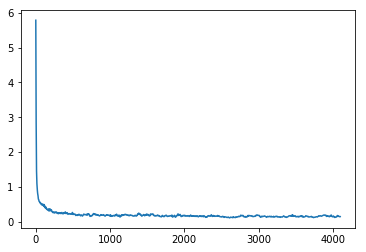

In [9]:
test_pretraining_dnn()

# Deep Autoencoder Visualization (X WING)

## Import the appropriate modules

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from util import relu, error_rate, getKaggleMNIST, init_weights
import os
import sys
from sklearn.mixture import GaussianMixture

## Layer class

In [2]:
class Layer(object):
    """
    initialize with weights
    """
    def __init__(self, m1, m2):
        W = init_weights((m1, m2))
        bi = np.zeros(m2)
        bo = np.zeros(m1)
        self.W = theano.shared(W)
        self.bi = theano.shared(bi)
        self.bo = theano.shared(bo)
        self.params = [self.W, self.bi, self.bo]
    """
    Forward for b in (W)
    """
    def forward(self, X):
        return T.nnet.sigmoid(X.dot(self.W) + self.bi)
    """
    forward for b out (W Transpose)
    """
    def forwardT(self, X):
        return T.nnet.sigmoid(X.dot(self.W.T) + self.bo)

## Deep Autoencoder class

In [9]:
class DeepAutoEncoder(object):
    """
    initializes hidden layer
    """
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes
    
    """
    fitting function
    learning rate, epochs, batch size can be varied
    """
    def fit(self, X, learning_rate=0.5, mu=0.99,
            epochs=50, batch_sz=100, show_fig=False):
        N, D = X.shape
        n_batches = N / batch_sz

        mi = D
        self.layers = []
        self.params = []
        for mo in self.hidden_layer_sizes:
            layer = Layer(mi, mo)
            self.layers.append(layer)
            self.params += layer.params
            mi = mo

        X_in = T.matrix('X')
        X_hat = self.forward(X_in)

        cost = -(X_in * T.log(X_hat) + (
            1 - X_in) * T.log(1 - X_hat)).mean()
        cost_op = theano.function(
            inputs=[X_in],
            outputs=cost,)

        dparams = [theano.shared(p.get_value()*0) for p in self.params]
        grads = T.grad(cost, self.params)

        updates = [(p, p + mu*dp - learning_rate*g
                   ) for p, dp, g in zip(self.params, dparams, grads)] 
        + [(dp, mu*dp - learning_rate*g ) for dp, g in zip(dparams, grads)]
        train_op = theano.function(
            inputs=[X_in],
            outputs=cost,
            updates=updates,)

        costs = []
        for i in range((int (epochs))):
            print ("epoch:", i)
            X = shuffle(X)
            for j in range((int (n_batches))):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                c = train_op(batch)
                if j % 100 == 0:
                    print ("j / n_batches:", j, "/", n_batches, "cost:", c)
                costs.append(c)
        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        Z = X
        for layer in self.layers:
            Z = layer.forward(Z)

        self.map2center = theano.function(
            inputs=[X],
            outputs=Z,)
        for i in range(len(self.layers)-1, -1, -1):
            Z = self.layers[i].forwardT(Z)
        return Z # Same size as X


## Running the Visualization

epoch: 0
j / n_batches: 0 / 410.0 cost: 0.7020471162337234
j / n_batches: 100 / 410.0 cost: 0.2712515695874863
j / n_batches: 200 / 410.0 cost: 0.26698960902078345
j / n_batches: 300 / 410.0 cost: 0.26302822764839096
j / n_batches: 400 / 410.0 cost: 0.2704759499123246
epoch: 1
j / n_batches: 0 / 410.0 cost: 0.26882262258231776
j / n_batches: 100 / 410.0 cost: 0.2675193930739754
j / n_batches: 200 / 410.0 cost: 0.2580064322151347
j / n_batches: 300 / 410.0 cost: 0.2581588350552051
j / n_batches: 400 / 410.0 cost: 0.24901186509239173
epoch: 2
j / n_batches: 0 / 410.0 cost: 0.2543028981448329
j / n_batches: 100 / 410.0 cost: 0.2495963580725604
j / n_batches: 200 / 410.0 cost: 0.23927744952824312
j / n_batches: 300 / 410.0 cost: 0.24564985456064656
j / n_batches: 400 / 410.0 cost: 0.2522890082711944
epoch: 3
j / n_batches: 0 / 410.0 cost: 0.24087965560559482
j / n_batches: 100 / 410.0 cost: 0.23761511319691092
j / n_batches: 200 / 410.0 cost: 0.23448779072717027
j / n_batches: 300 / 410.0 

j / n_batches: 100 / 410.0 cost: 0.20810735665369096
j / n_batches: 200 / 410.0 cost: 0.2002367419968715
j / n_batches: 300 / 410.0 cost: 0.1956474212550384
j / n_batches: 400 / 410.0 cost: 0.1948088715383466
epoch: 31
j / n_batches: 0 / 410.0 cost: 0.20737438337075909
j / n_batches: 100 / 410.0 cost: 0.19918924876913724
j / n_batches: 200 / 410.0 cost: 0.20730117577644677
j / n_batches: 300 / 410.0 cost: 0.20235832844023172
j / n_batches: 400 / 410.0 cost: 0.20382079779575243
epoch: 32
j / n_batches: 0 / 410.0 cost: 0.19721274854884496
j / n_batches: 100 / 410.0 cost: 0.20295198080919308
j / n_batches: 200 / 410.0 cost: 0.2041346384006523
j / n_batches: 300 / 410.0 cost: 0.19513947971843923
j / n_batches: 400 / 410.0 cost: 0.20276692608469463
epoch: 33
j / n_batches: 0 / 410.0 cost: 0.19236380550654153
j / n_batches: 100 / 410.0 cost: 0.18738118091384462
j / n_batches: 200 / 410.0 cost: 0.20036386999297204
j / n_batches: 300 / 410.0 cost: 0.19271369916655212
j / n_batches: 400 / 410.0

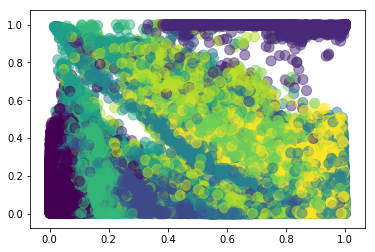

In [10]:
Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
dae = DeepAutoEncoder([500, 300, 2])
dae.fit(Xtrain)
mapping = dae.map2center(Xtrain)
plt.scatter(mapping[:,0], mapping[:,1], c=Ytrain, s=100, alpha=0.5)
plt.show()

Great Classification after 50 epochs!